In [140]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats.mstats import winsorize

# Discovering
## 1/ Import data

In [141]:
df = pd.read_csv('us_real_estate.csv')
df.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001666 entries, 0 to 2001665
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   status          object 
 1   bed             float64
 2   bath            float64
 3   acre_lot        float64
 4   city            object 
 5   state           object 
 6   zip_code        float64
 7   house_size      float64
 8   prev_sold_date  object 
 9   price           float64
dtypes: float64(6), object(4)
memory usage: 152.7+ MB


## 2/ Remove null
Remove all entries with unknown information, except for:
* `prev_sold_date`, as we consider both sold and unsold houses
*  `bed`,`bath` & `acre_lot`, as unbuilt houses' space areas and bathrooms are unknown

*Duplicates are accepcted in this case*

In [143]:
# Except from those 4 columns, delete all nan
df = df.dropna(axis=0, subset= df.columns.delete([1,2,3,8]), ignore_index=True)

In [144]:
# drop those not UNBUILT but still empty those 3 columns
drop_for_sale = df[(df['status'] != 'ready_to_build') & ((df['bed'].isna() == True) | (df['bath'].isna() == True) | (df['acre_lot'].isna() == True))]
df = df.drop(drop_for_sale.index, axis=0)

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1050751 entries, 0 to 1356096
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   status          1050751 non-null  object 
 1   bed             1050751 non-null  float64
 2   bath            1028061 non-null  float64
 3   acre_lot        1028061 non-null  float64
 4   city            1050751 non-null  object 
 5   state           1050751 non-null  object 
 6   zip_code        1050751 non-null  float64
 7   house_size      1050751 non-null  float64
 8   prev_sold_date  614358 non-null   object 
 9   price           1050751 non-null  float64
dtypes: float64(6), object(4)
memory usage: 88.2+ MB


## 3/ Drop unnecessary columns
`zip_code`

In [146]:
df.drop(['zip_code'], axis=1, inplace=True)

## 3/ Convert data
### Dtype

In [147]:
df['prev_sold_date'] = pd.to_datetime(df['prev_sold_date'])

### Unit
acre to square feet

In [148]:
df['land_size'] = df['acre_lot']*43560
df = df.drop('acre_lot', axis=1)

## 4/ Outliers & Duplicates

In [149]:
df.describe()

,bed,bath,house_size,prev_sold_date,price,land_size
count,1.050751e+06,1.028061e+06,1.050751e+06,614358,1.050751e+06,1.028061e+06
mean,3.662596e+00,2.539920e+00,2.271826e+03,2009-04-19 15:40:46.374263296,5.860164e+05,1.218176e+06
min,1.000000e+00,1.000000e+00,1.000000e+02,1901-01-01 00:00:00,1.000000e+00,0.000000e+00
25%,3.000000e+00,2.000000e+00,1.344000e+03,2003-01-03 00:00:00,1.899000e+05,5.227200e+03
50%,3.000000e+00,2.000000e+00,1.834000e+03,2011-04-15 00:00:00,3.420000e+05,1.176120e+04
75%,4.000000e+00,3.000000e+00,2.600000e+03,2018-02-08 00:00:00,5.999000e+05,3.702600e+04
max,9.900000e+01,1.980000e+02,1.450112e+06,2023-03-01 00:00:00,1.690000e+08,4.356000e+09
std,1.834364e+00,1.806045e+00,3.188832e+03,NaN,1.276759e+06,5.332165e+07


Some abnormal patterns can be detected:
* The max numbers of `bed` and `bath` are 99 and 198, respectively, which is unreal
* The range of `acre_lot` is from 0 (unreal) to 100K (too big). The same goes for `house_size` and `price`
* The latest `prev_sold_date` is in 2073, which is far from now

### Visualization (boxplot)

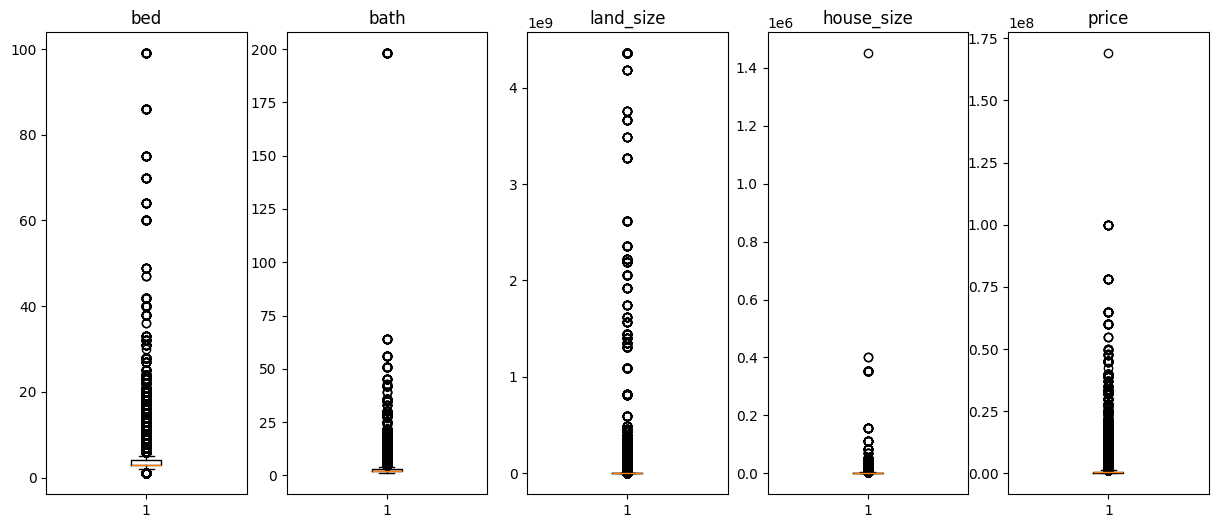

In [150]:
fig, axes = plt.subplots(1,5, sharex=False, sharey=False)
fig.set_size_inches(15,6)

axes[0].boxplot(df['bed'])
axes[0].set_title('bed')

axes[1].boxplot(df[df['bath'].isna()==False]['bath'])
axes[1].set_title('bath')

axes[2].boxplot(df[df['land_size'].isna()==False]['land_size'])
axes[2].set_title('land_size')

axes[3].boxplot(df['house_size'])
axes[3].set_title('house_size')

axes[4].boxplot(df['price'])
axes[4].set_title('price')

plt.show()

### Remove outlier

In [151]:
# OUTLIER

print('Entries before remove', len(df))

for column in ['bed','bath','land_size','house_size','price']:
    # if df.dtypes[column] in ['float64', '<M8[ns]']:
    notnull_series = df[df[column].isna()==False][column]
    q1 = np.quantile(notnull_series, 0.25)
    q3 = np.quantile(notnull_series, 0.75)
    iqr = q3-q1
    upper_bound = q3 + 1.5*iqr
    lower_bound = q1 - 1.5*iqr
    outlier = df[(df[column]>upper_bound) | (df[column]<lower_bound)][column]
    df = df.drop(outlier.index)
    print('Entries after remove',column, len(df))
    


Entries before remove 1050751
Entries after remove bed 936186
Entries after remove bath 900749
Entries after remove land_size 779760
Entries after remove house_size 755836
Entries after remove price 720524


In [152]:
# INVALID DATE
print('Entries before remove', len(df))

invalid_date = df[df['prev_sold_date'].dt.year > 2023]
df = df.drop(invalid_date.index)

print('Entries after remove',column, len(df))

Entries before remove 720524
Entries after remove price 720524


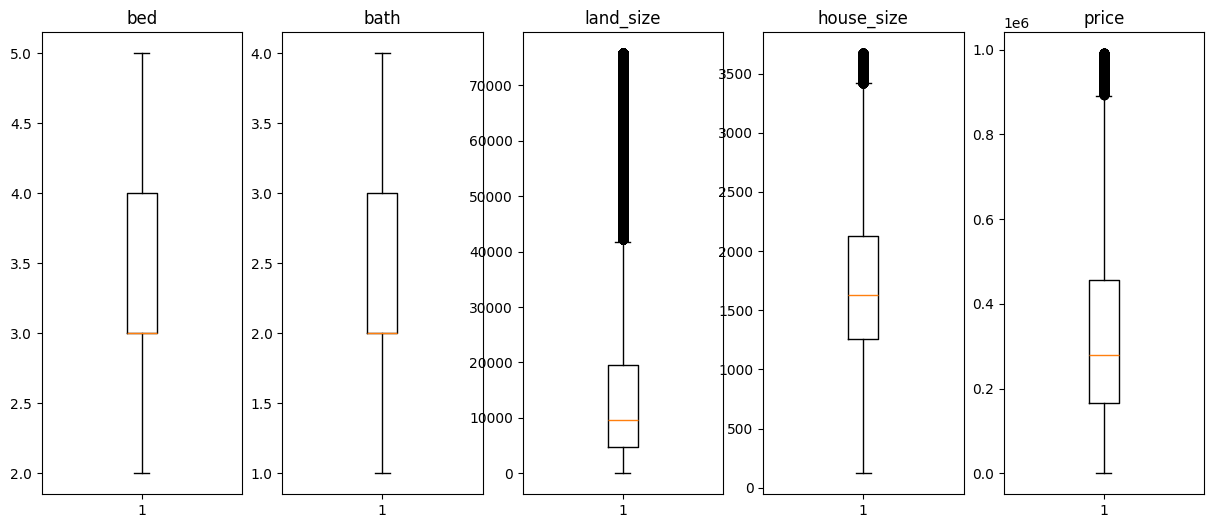

In [153]:
fig, axes = plt.subplots(1,5, sharex=False, sharey=False)
fig.set_size_inches(15,6)

axes[0].boxplot(df['bed'])
axes[0].set_title('bed')

axes[1].boxplot(df[df['bath'].isna()==False]['bath'])
axes[1].set_title('bath')

axes[2].boxplot(df[df['land_size'].isna()==False]['land_size'])
axes[2].set_title('land_size')

axes[3].boxplot(df['house_size'])
axes[3].set_title('house_size')

axes[4].boxplot(df['price'])
axes[4].set_title('price')

plt.show()

In [154]:
df.describe()

,bed,bath,house_size,prev_sold_date,price,land_size
count,720524.000000,699579.000000,720524.000000,445401,720524.000000,699579.000000
mean,3.241286,2.112260,1745.273332,2009-07-17 00:56:56.419810304,331117.357806,15022.007333
min,2.000000,1.000000,122.000000,1901-01-01 00:00:00,1.000000,0.000000
25%,3.000000,2.000000,1260.000000,2003-06-19 00:00:00,165000.000000,4791.600000
50%,3.000000,2.000000,1628.000000,2011-11-15 00:00:00,279900.000000,9583.200000
75%,4.000000,3.000000,2125.000000,2018-04-03 00:00:00,455900.000000,19602.000000
max,5.000000,4.000000,3671.000000,2023-03-01 00:00:00,991190.000000,75794.400000
std,0.791686,0.820459,633.845139,NaN,215379.743954,15264.303125


## 5/ Winsorize
The 1% of the lowest value and the 1% of the highest values are replaced.

In [155]:
df['price'] = winsorize(df['price'], limits=[0.01, 0.01])
df['house_size'] = winsorize(df['house_size'], limits=[0.01, 0.01])
df['land_size'] = winsorize(df['land_size'], limits=[0.01, 0.01])

df.describe()

c:\Users\ASUS FLIP 14\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\ASUS FLIP 14\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\ASUS FLIP 14\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\ASUS FLIP 14\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\ASUS FLIP 14\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of

,bed,bath,house_size,prev_sold_date,price,land_size
count,720524.000000,699579.000000,720524.000000,445401,720524.000000,699579.000000
mean,3.241286,2.112260,1745.114650,2009-07-17 00:56:56.419810304,330850.574149,15026.645529
min,2.000000,1.000000,720.000000,1901-01-01 00:00:00,32000.000000,871.200000
25%,3.000000,2.000000,1260.000000,2003-06-19 00:00:00,165000.000000,4791.600000
50%,3.000000,2.000000,1628.000000,2011-11-15 00:00:00,279900.000000,9583.200000
75%,4.000000,3.000000,2125.000000,2018-04-03 00:00:00,455900.000000,19602.000000
max,5.000000,4.000000,3489.000000,2023-03-01 00:00:00,920000.000000,75794.400000
std,0.791686,0.820459,629.484162,NaN,214172.784138,15259.916243


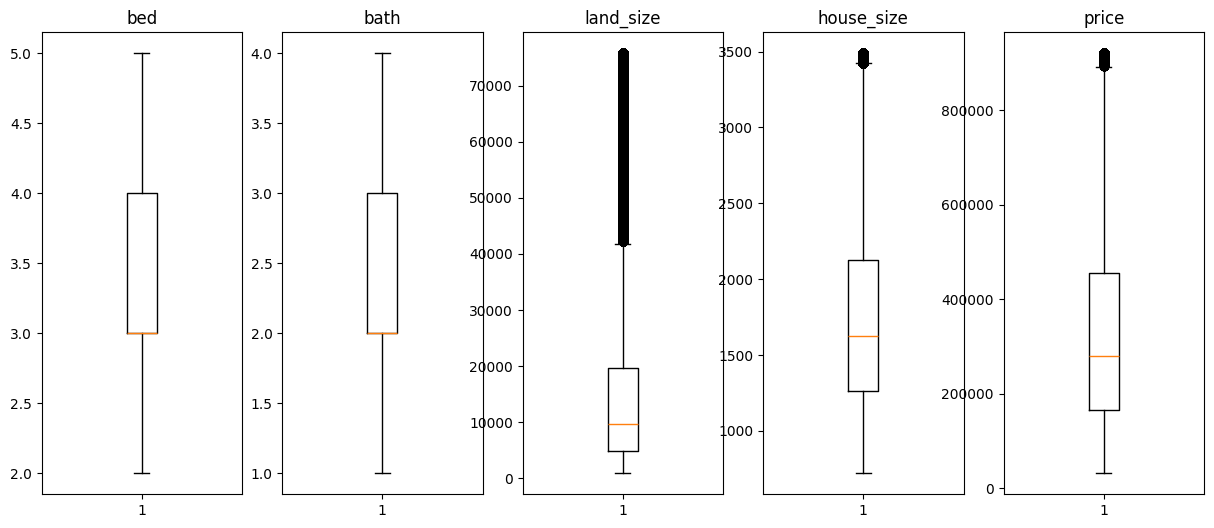

In [156]:
fig, axes = plt.subplots(1,5, sharex=False, sharey=False)
fig.set_size_inches(15,6)

axes[0].boxplot(df['bed'])
axes[0].set_title('bed')

axes[1].boxplot(df[df['bath'].isna()==False]['bath'])
axes[1].set_title('bath')

axes[2].boxplot(df[df['land_size'].isna()==False]['land_size'])
axes[2].set_title('land_size')

axes[3].boxplot(df['house_size'])
axes[3].set_title('house_size')

axes[4].boxplot(df['price'])
axes[4].set_title('price')

plt.show()

## 6/ Questioning
* How many houses that were sold before?
    * Are houses that were sold before lower in price compared to those newly sale?
* How many for sale, how many ready to build?
    * Which is more expensive, on average?
* Which states have the greatest number of houses for sale?
    * *(if ok)* Where are they in the US map?
* How many bedrooms/ bathrooms in typical?
* Which months houses are sold the most?
* How are the prices?
    * For those whose sizes are over (below) average, what are their characteristics: (1) size, (2) bedroom, (3) bathroom, (4) living space, (5) states, (6) previous sold?

# Joining
For further analysis on location, `lat` and `long` will be added
* Data source: https://simplemaps.com/data/us-cities
* Because some cities don't have coordination available, the state coordination will represent

In [157]:
joining_state = pd.read_csv('us_geo.csv')
joining_state = joining_state[['Name','latitude','longitude']]

In [158]:
df = pd.merge(df,joining_state, left_on=['state'], right_on=['Name'], how='left')
df = df.drop('Name', axis=1)

In [159]:
joining_cities = pd.read_csv('uscities.csv')[['city','state_name','lat','lng']]
df = pd.merge(df,joining_cities, left_on=['city','state'], right_on=['city','state_name'], how='left')

# With cities coor available, replace state coor by the city's coor
df[df['lat'].isna()==False]['latitude'] = df[df['lat'].isna()==False]['lat']
df[df['lng'].isna()==False]['longitude'] = df[df['lng'].isna()==False]['lng']

df = df.drop(['state_name','lat','lng'], axis=1)

C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\356377281.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['lat'].isna()==False]['latitude'] = df[df['lat'].isna()==False]['lat']
C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\356377281.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['lng'].isna()==False]['longitude'] = df[df['lng'].isna()==False]['lng']


# Analyzing
**Q1: How many for sale, how many ready to build?**

In [160]:
df[['status','price']].groupby(['status']).agg(
    number_of_houses = pd.NamedAgg(column='price', aggfunc='count')
    , max_price = pd.NamedAgg(column='price', aggfunc='max')
    , min_price = pd.NamedAgg(column='price', aggfunc='min')
    , average_price = pd.NamedAgg(column='price', aggfunc=np.mean)
).reset_index()

C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\3081596903.py:1: FutureWarning: The provided callable <function mean at 0x000001FAFEAE28E0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df[['status','price']].groupby(['status']).agg(


,status,number_of_houses,max_price,min_price,average_price
0,for_sale,711877,920000.0,32000.0,323165.092748
1,ready_to_build,20945,920000.0,243990.0,509732.226164


Finding 1
* The number of houses for sales is much higher than raw land, and more expensive on average
* The prices of houses for sales range broader, it can be very low ($3000), also can be vwey high ($500K)

**Q2: Which states have the greatest number of houses for sale?**

In [161]:
price_by_state = df[['state','price']].groupby(['state']).agg(
                    number_of_houses = pd.NamedAgg(column='price', aggfunc='count')
                    , max_price = pd.NamedAgg(column='price', aggfunc='max')
                    , min_price = pd.NamedAgg(column='price', aggfunc='min')
                    , average_price = pd.NamedAgg(column='price', aggfunc=np.mean)
).sort_values('average_price').reset_index()

C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\4054545661.py:1: FutureWarning: The provided callable <function mean at 0x000001FAFEAE28E0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  price_by_state = df[['state','price']].groupby(['state']).agg(


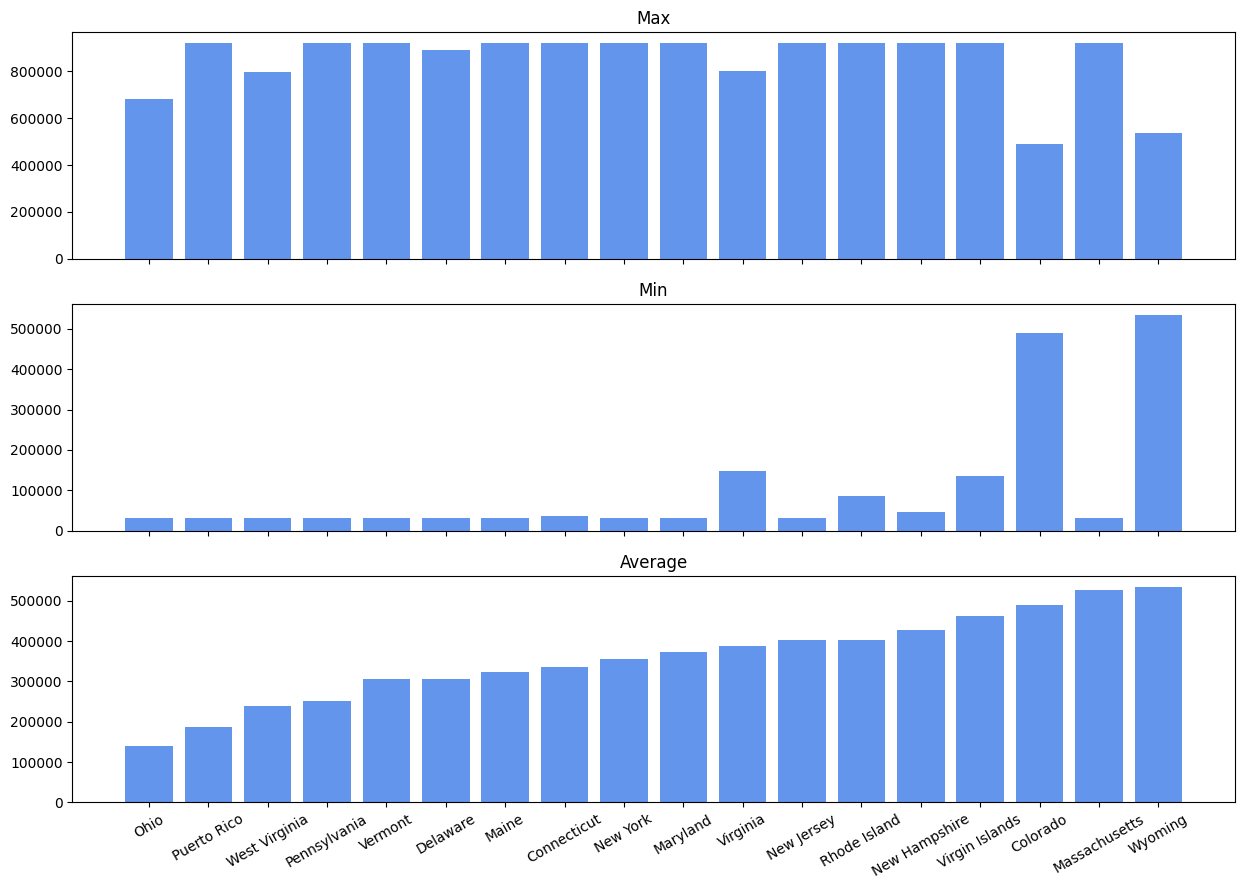

In [162]:
fig, axes = plt.subplots(3,1, sharex=True)
fig.set_size_inches(15,10)

axes[0].bar(height=price_by_state['max_price'], x=price_by_state['state'], color='cornflowerblue')
axes[1].bar(height=price_by_state['min_price'], x=price_by_state['state'], color='cornflowerblue')
axes[2].bar(height=price_by_state['average_price'], x=price_by_state['state'], color='cornflowerblue')

axes[0].set_title('Max')
axes[1].set_title('Min')
axes[2].set_title('Average')


plt.xticks(rotation=30)

plt.show()

Finding 2
* Colorado is the state with least number of houses sold, and the most expensive house here is the lowest among the most expensive. However, contrastly, the cheapest in Wyoming is the most valuable among the cheapest. A reverse conclusions can be pointed out in Penn.
    * An interesting pattern: **The more houses are on sales, the more broader the price range is.**


**Q3: How many houses that were sold before?**

In [163]:
only_new = df[df['prev_sold_date'].dt.year.isna()]

by_new_houses = only_new[['state','price']].groupby(['state']).agg(
                    number_of_new_houses = pd.NamedAgg(column='price', aggfunc='count')
                    , max_price = pd.NamedAgg(column='price', aggfunc='max')
                    , min_price = pd.NamedAgg(column='price', aggfunc='min')
                    , average_price = pd.NamedAgg(column='price', aggfunc=np.mean)
).sort_values('number_of_new_houses').reset_index()

C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\3306344269.py:3: FutureWarning: The provided callable <function mean at 0x000001FAFEAE28E0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  by_new_houses = only_new[['state','price']].groupby(['state']).agg(


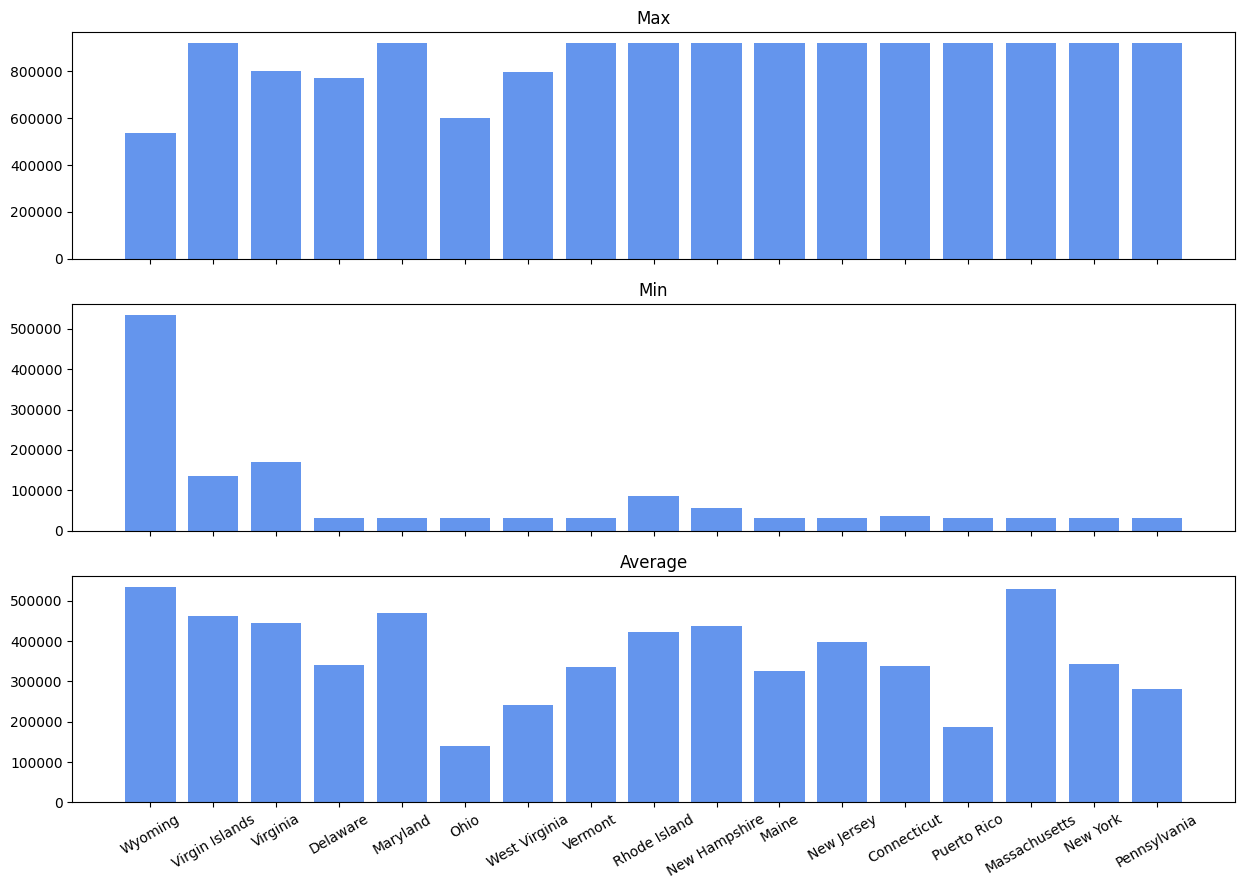

In [164]:
fig, axes = plt.subplots(3,1, sharex=True)
fig.set_size_inches(15,10)

axes[0].bar(height=by_new_houses['max_price'], x=by_new_houses['state'], color='cornflowerblue')
axes[1].bar(height=by_new_houses['min_price'], x=by_new_houses['state'], color='cornflowerblue')
axes[2].bar(height=by_new_houses['average_price'], x=by_new_houses['state'], color='cornflowerblue')

axes[0].set_title('Max')
axes[1].set_title('Min')
axes[2].set_title('Average')


plt.xticks(rotation=30)

plt.show()

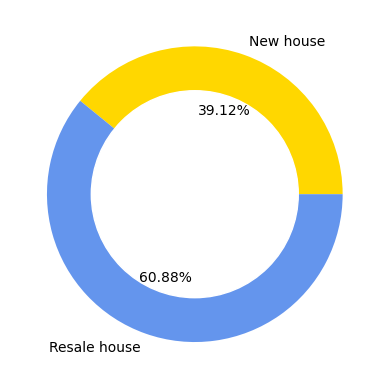

In [165]:
plt.pie([len(only_new), len(df)-len(only_new)]
        , labels=['New house', 'Resale house']
        , autopct='%.2f%%'
        , colors=['gold','cornflowerblue'])

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

Finding 3
* Same pattern as finding 2: **In general, the more houses are on sales, the more expensive on average**
* Wyoming and NYC are the states with least and most houses sold before
* The number of 2-hand land is higher

**Q3+: In each state, which is the proportion of new and 2-hand houses**

In [166]:
new_to_total_houses_by_state = pd.merge(price_by_state, by_new_houses, left_on=['state'], right_on=['state'], how='inner').sort_values('average_price_x')[['state','number_of_houses','number_of_new_houses']]

In [167]:
new_to_total_houses_by_state['pct_new_houses'] = new_to_total_houses_by_state['number_of_new_houses']/new_to_total_houses_by_state['number_of_houses']*100

In [168]:
new_to_total_houses_by_state

,state,number_of_houses,number_of_new_houses,pct_new_houses
0,Ohio,6409,2480,38.695584
1,Puerto Rico,22458,22458,100.000000
2,West Virginia,5837,3067,52.544115
3,Pennsylvania,255273,95644,37.467339
4,Vermont,10149,5515,54.340329
5,Delaware,1686,449,26.631079
6,Maine,11787,9218,78.204802
7,Connecticut,48738,14524,29.800156
8,New York,217408,75017,34.505170
9,Maryland,5558,2383,42.875135


C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\1697877454.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=new_to_total_houses_by_state['state'], rotation=90, ha='center')


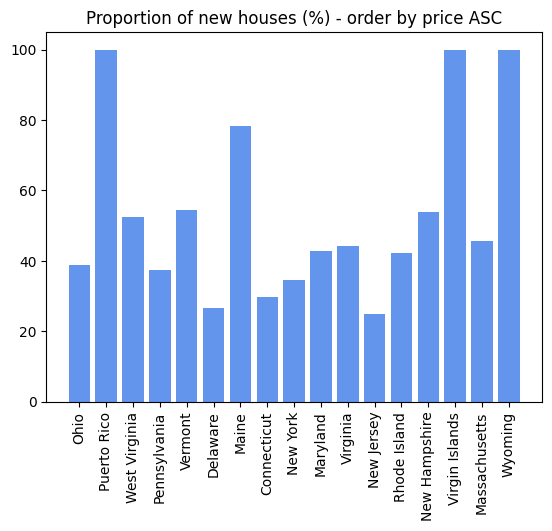

In [169]:
plt.bar(new_to_total_houses_by_state['state']
        ,new_to_total_houses_by_state['pct_new_houses']
        , color='cornflowerblue')

ax = plt.gca()
ax.set_xticklabels(labels=new_to_total_houses_by_state['state'], rotation=90, ha='center')
plt.title('Proportion of new houses (%) - order by price ASC')

plt.show()

Finding 3*

There is no relationship between the price and the proportion of new houses


**Q4. How many bedrooms and bathrooms in general?**

**Q4+: What is the characteristics of each bedroom/ bathroom type?**

In [170]:
by_bed = df[['bed','price', 'house_size','bath']].groupby(['bed']).agg(
                    number_of_houses = pd.NamedAgg(column='price', aggfunc='count')
                    , max_price = pd.NamedAgg(column='price', aggfunc='max')
                    , min_price = pd.NamedAgg(column='price', aggfunc='min')
                    , average_price = pd.NamedAgg(column='price', aggfunc=np.mean)
                    , average_area = pd.NamedAgg(column='house_size', aggfunc=np.mean)
                    , number_of_bathroom = pd.NamedAgg(column='bath', aggfunc=np.mean)
).reset_index().sort_values('bed')

C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\3271915099.py:1: FutureWarning: The provided callable <function mean at 0x000001FAFEAE28E0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  by_bed = df[['bed','price', 'house_size','bath']].groupby(['bed']).agg(


In [171]:
by_bed

,bed,number_of_houses,max_price,min_price,average_price,average_area,number_of_bathroom
0,2.0,116360,920000.0,32000.0,258993.546975,1219.398651,1.563972
1,3.0,367547,920000.0,32000.0,305281.214408,1596.036444,2.001871
2,4.0,203499,920000.0,32000.0,394201.930658,2164.578509,2.503597
3,5.0,45416,920000.0,32000.0,400051.873393,2357.820746,2.696842


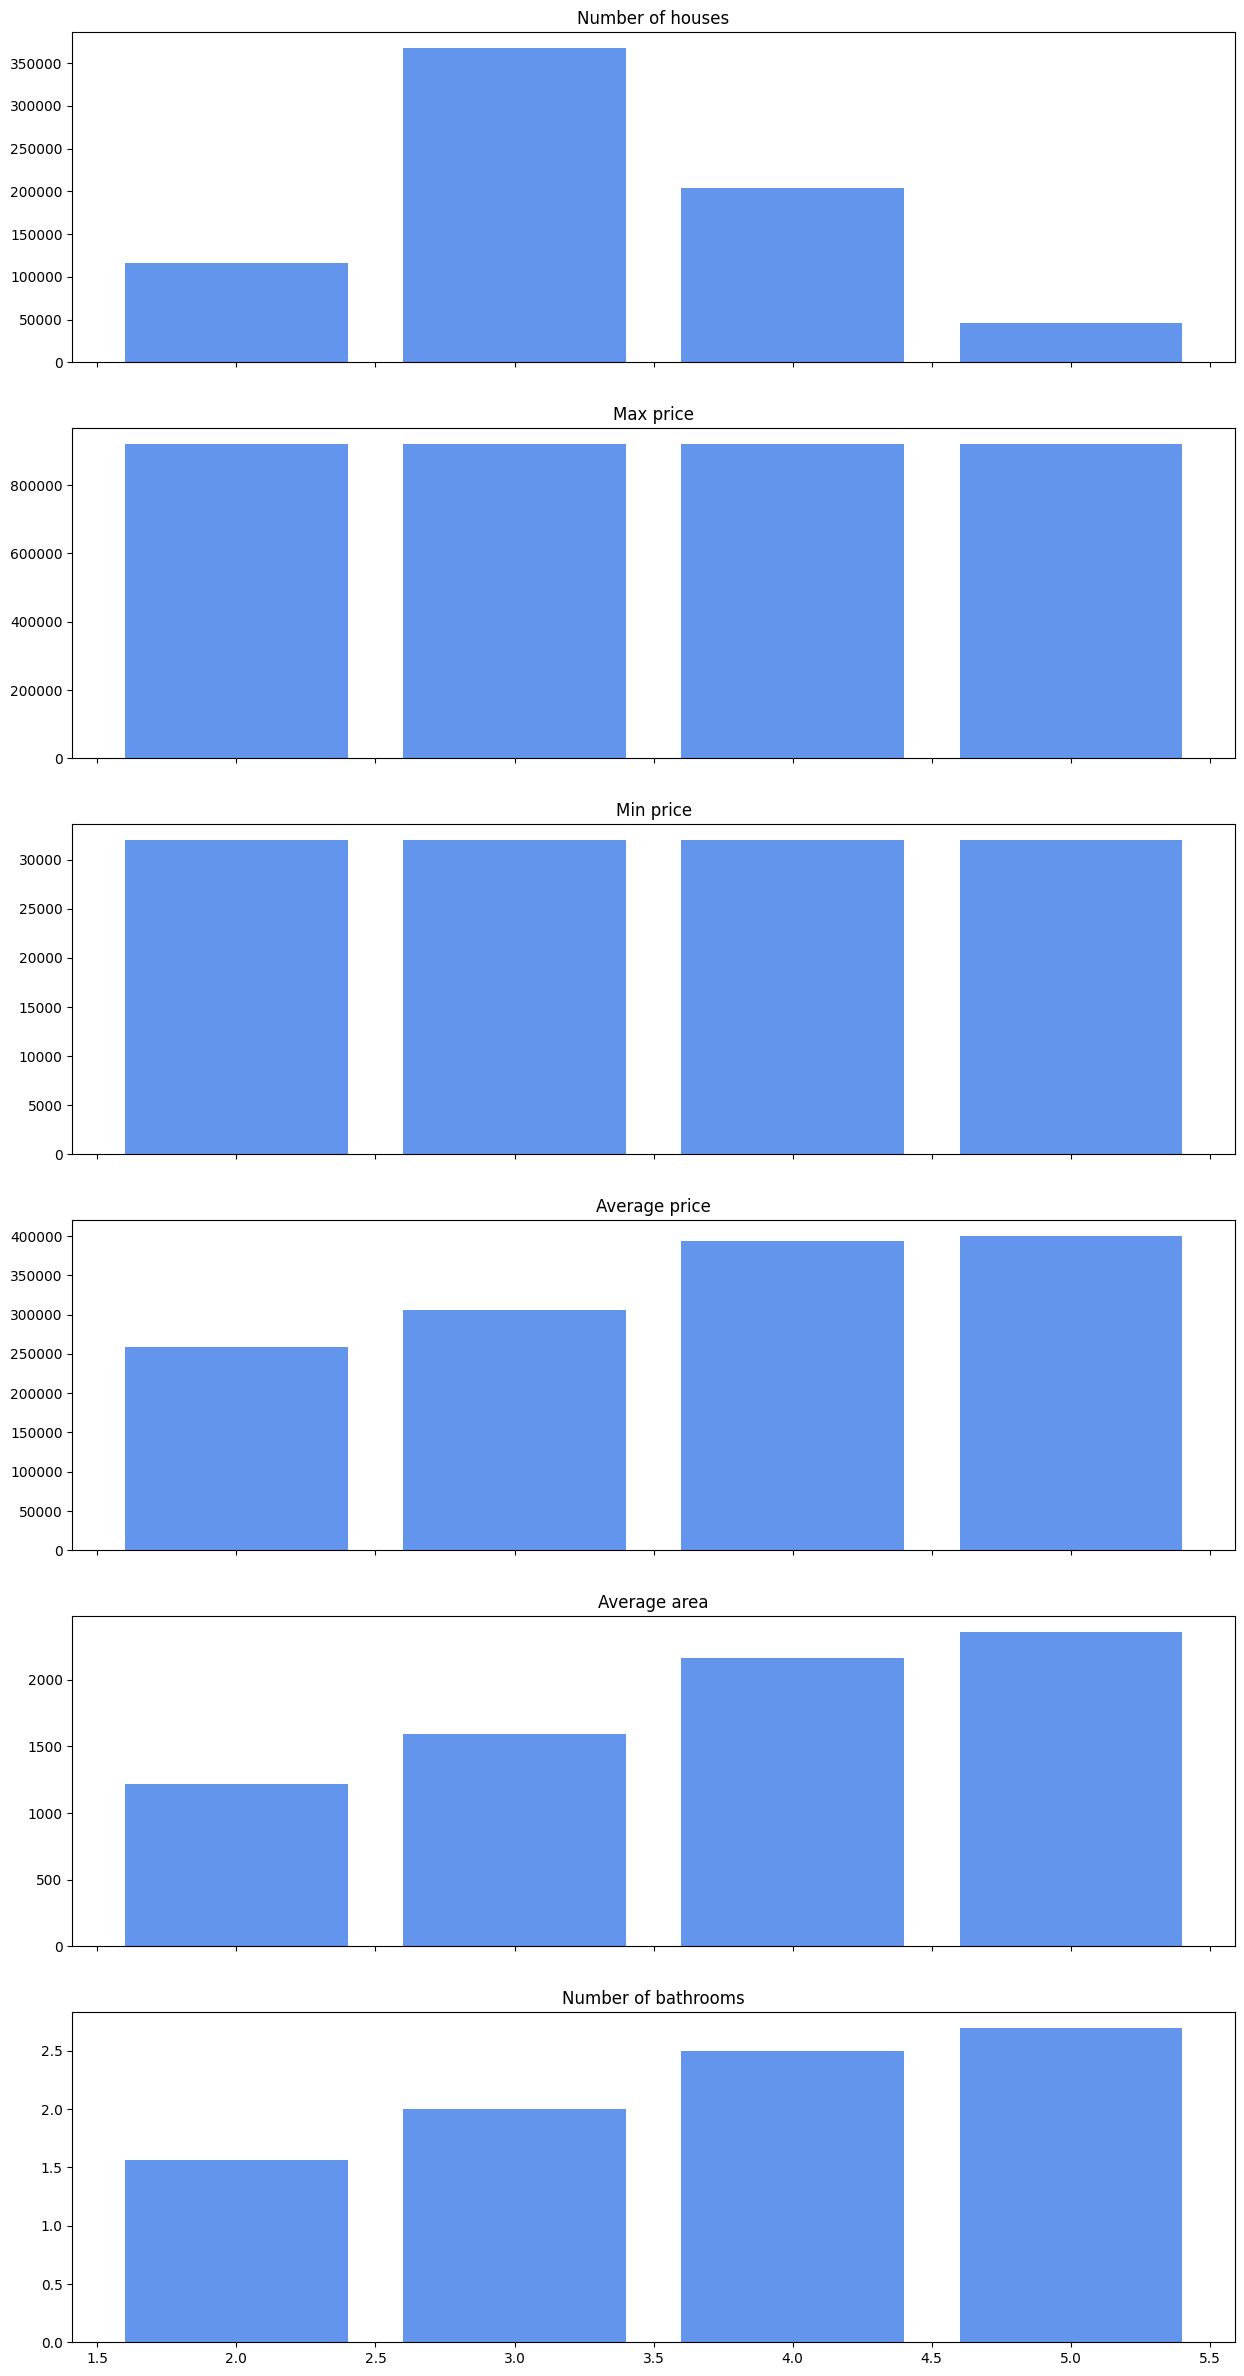

In [172]:
fig, axes = plt.subplots(6,1, sharex=True)
fig.set_size_inches(15,30)

axes[0].bar(height=by_bed['number_of_houses'], x=by_bed['bed'], color='cornflowerblue')
axes[1].bar(height=by_bed['max_price'], x=by_bed['bed'], color='cornflowerblue')
axes[2].bar(height=by_bed['min_price'], x=by_bed['bed'], color='cornflowerblue')
axes[3].bar(height=by_bed['average_price'], x=by_bed['bed'], color='cornflowerblue')
axes[4].bar(height=by_bed['average_area'], x=by_bed['bed'], color='cornflowerblue')
axes[5].bar(height=by_bed['number_of_bathroom'], x=by_bed['bed'], color='cornflowerblue')


axes[0].set_title('Number of houses')
axes[1].set_title('Max price')
axes[2].set_title('Min price')
axes[3].set_title('Average price')
axes[4].set_title('Average area')
axes[5].set_title('Number of bathrooms')


plt.show()

In [173]:
by_bath = df[['bath','price', 'house_size','bed']].groupby(['bath']).agg(
                    number_of_houses = pd.NamedAgg(column='price', aggfunc='count')
                    , max_price = pd.NamedAgg(column='price', aggfunc='max')
                    , min_price = pd.NamedAgg(column='price', aggfunc='min')
                    , average_price = pd.NamedAgg(column='price', aggfunc=np.mean)
                    , average_area = pd.NamedAgg(column='house_size', aggfunc=np.mean)
                    , number_of_bedroom = pd.NamedAgg(column='bed', aggfunc=np.mean)
).reset_index().sort_values('bath')

C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\2691306330.py:1: FutureWarning: The provided callable <function mean at 0x000001FAFEAE28E0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  by_bath = df[['bath','price', 'house_size','bed']].groupby(['bath']).agg(


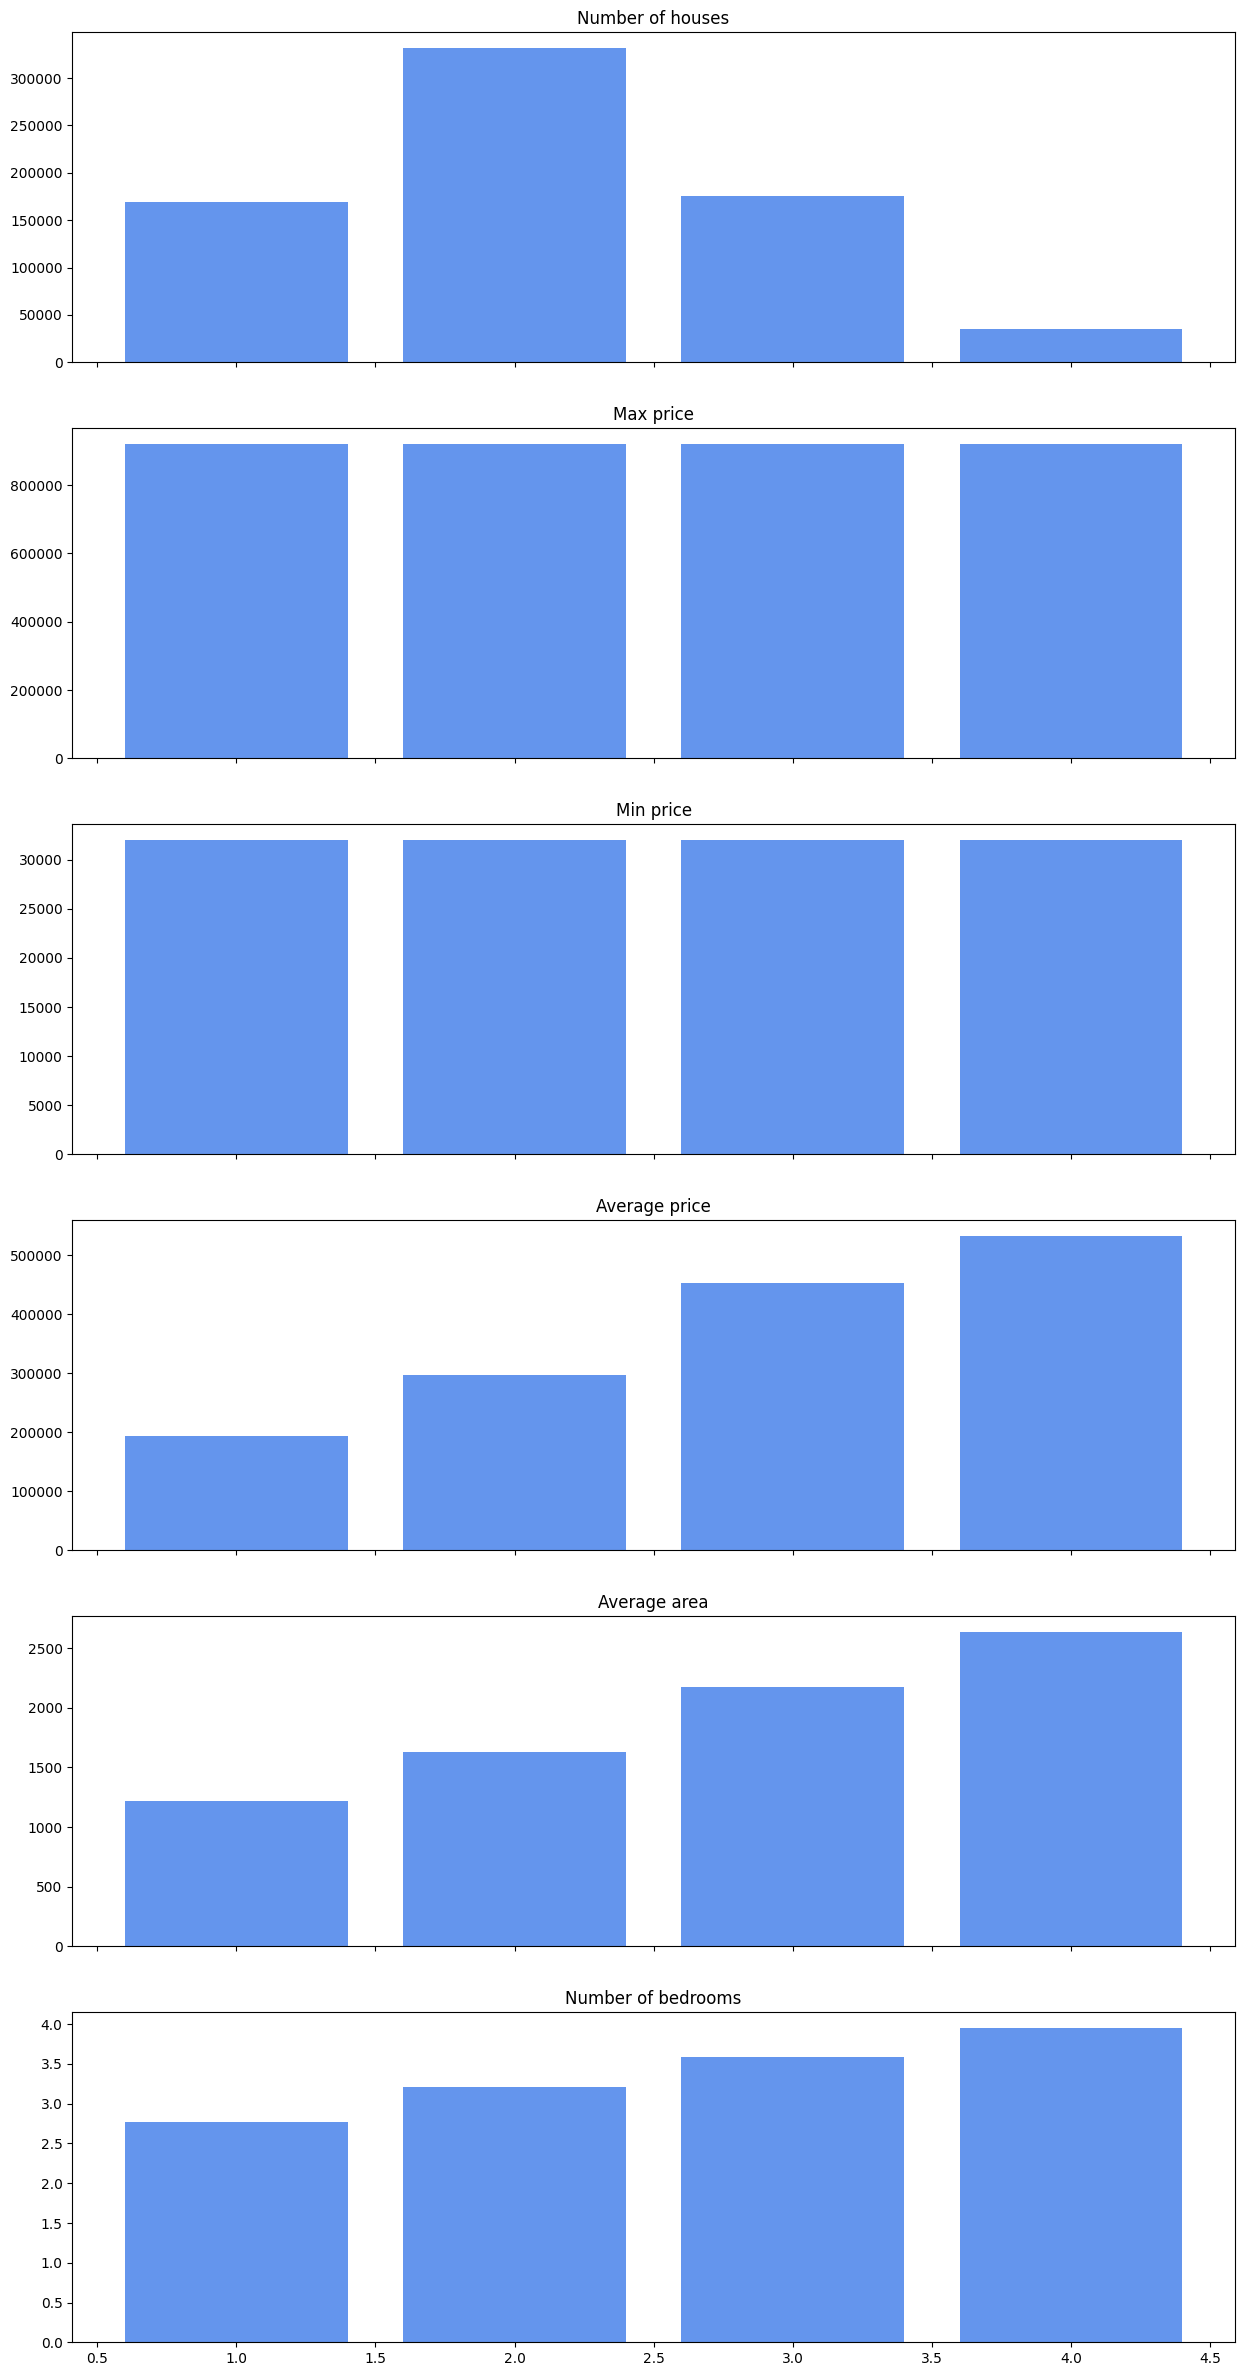

In [174]:
fig, axes = plt.subplots(6,1, sharex=True)
fig.set_size_inches(15,30)

axes[0].bar(height=by_bath['number_of_houses'], x=by_bath['bath'], color='cornflowerblue')
axes[1].bar(height=by_bath['max_price'], x=by_bath['bath'], color='cornflowerblue')
axes[2].bar(height=by_bath['min_price'], x=by_bath['bath'], color='cornflowerblue')
axes[3].bar(height=by_bath['average_price'], x=by_bath['bath'], color='cornflowerblue')
axes[4].bar(height=by_bath['average_area'], x=by_bath['bath'], color='cornflowerblue')
axes[5].bar(height=by_bath['number_of_bedroom'], x=by_bath['bath'], color='cornflowerblue')


axes[0].set_title('Number of houses')
axes[1].set_title('Max price')
axes[2].set_title('Min price')
axes[3].set_title('Average price')
axes[4].set_title('Average area')
axes[5].set_title('Number of bedrooms')


plt.show()

Finding 4
* The more bedrooms and bathrooms, the larger, the more expensive and the more number of bathromms ans bedrooms
* 3-bedroom houses are the most common, same for 2-bathroom type
* The most expensive houses belong to the least-bed(bath) category, and vice versa for the cheapest

**Q5: In which months houses are sold the most?**

**Q5+: In which year/month was houses were bouhgt at highest price**

In [175]:
only_prev_sold = df[df['prev_sold_date'].dt.year.isna()==False]
only_prev_sold['prev_sold_year'] = only_prev_sold['prev_sold_date'].dt.year
only_prev_sold['prev_sold_month'] = only_prev_sold['prev_sold_date'].dt.month

C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\3519076073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_prev_sold['prev_sold_year'] = only_prev_sold['prev_sold_date'].dt.year
C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\3519076073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_prev_sold['prev_sold_month'] = only_prev_sold['prev_sold_date'].dt.month


In [176]:
by_year = only_prev_sold[['prev_sold_year','price']].groupby('prev_sold_year').agg(
                    number_of_houses = pd.NamedAgg(column='price', aggfunc='count')
                    , max_price = pd.NamedAgg(column='price', aggfunc='max')
                    , min_price = pd.NamedAgg(column='price', aggfunc='min')
                    , average_price = pd.NamedAgg(column='price', aggfunc=np.mean)
).reset_index().sort_values('prev_sold_year')

C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\2062122675.py:1: FutureWarning: The provided callable <function mean at 0x000001FAFEAE28E0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  by_year = only_prev_sold[['prev_sold_year','price']].groupby('prev_sold_year').agg(


In [177]:
by_month = only_prev_sold[['prev_sold_month','price']].groupby('prev_sold_month').agg(
                    number_of_houses = pd.NamedAgg(column='price', aggfunc='count')
                    , max_price = pd.NamedAgg(column='price', aggfunc='max')
                    , min_price = pd.NamedAgg(column='price', aggfunc='min')
                    , average_price = pd.NamedAgg(column='price', aggfunc=np.mean)
).reset_index().sort_values('prev_sold_month')

C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\975392113.py:1: FutureWarning: The provided callable <function mean at 0x000001FAFEAE28E0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  by_month = only_prev_sold[['prev_sold_month','price']].groupby('prev_sold_month').agg(


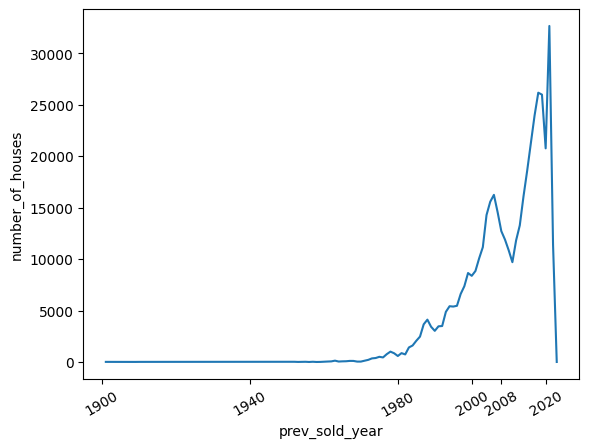

In [178]:
sns.lineplot(by_year, x='prev_sold_year', y='number_of_houses')
plt.xticks([1900,1940, 1980, 2000, 2008, 2020], rotation=30)
plt.show()

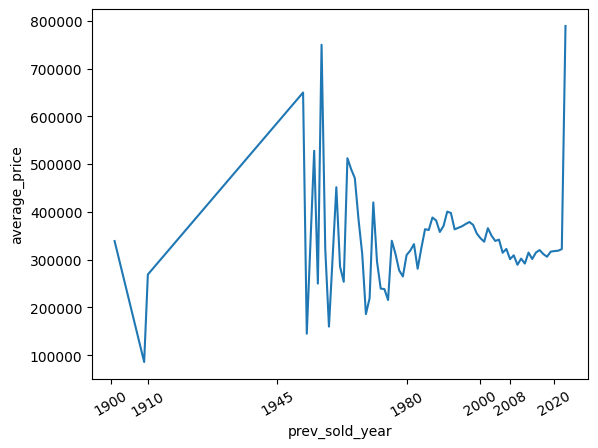

In [179]:
sns.lineplot(by_year, x='prev_sold_year', y='average_price')
plt.xticks([1900, 1910, 1945, 1980, 2000, 2008, 2020], rotation=30)
plt.show()

<Axes: xlabel='prev_sold_month', ylabel='average_price'>

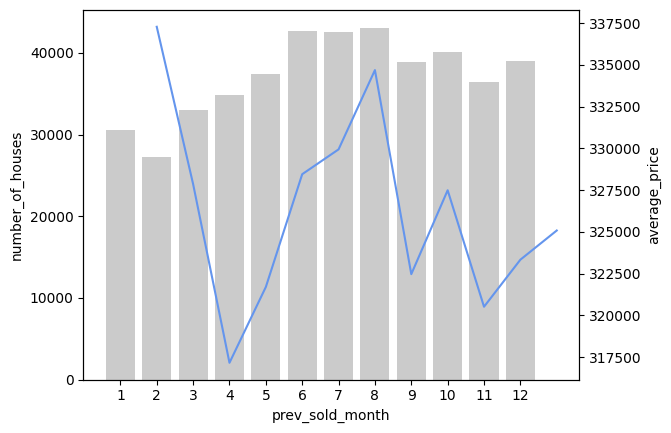

In [180]:
sns.barplot(by_month, x='prev_sold_month', y='number_of_houses', color='#555555',alpha=0.3)

ax2=plt.twinx()
sns.lineplot(by_month, x='prev_sold_month', y='average_price', color='cornflowerblue', ax=ax2)

Finding 5
* Jun-Aug (middle of a year) are when houses were sold the most
* First half was least favourable months to sell - both quantity and price
* **In general, price and houses sold move together**
* Noticeable months:
    * Feb: Lowest sold, highest price
    * Apr: Lowest price
    * Aug: Highest sold, high price

**Q6: Did multi-floor houses have higher price than one-floor houses**

Assuming that entries with `house_size` > `land_size` belongs to multi-floor houses

In [181]:
multi_floor = df[df['house_size']>df['land_size']]
one_floor = df[df['land_size']>=df['house_size']]

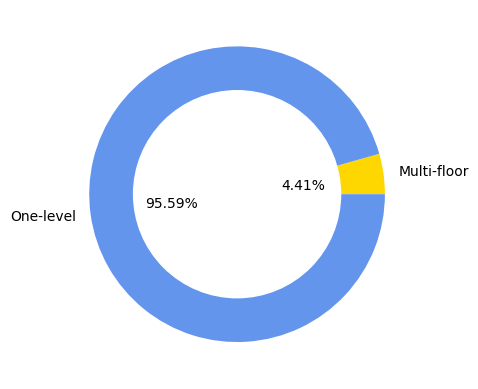

In [182]:
plt.pie([len(multi_floor), len(df)-len(multi_floor)]
        , labels=['Multi-floor', 'One-level']
        , autopct='%.2f%%'
        , colors=['gold','cornflowerblue']
        , pctdistance=0.45)

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

In [183]:
from scipy.stats import ttest_ind

ttest_ind(multi_floor['price'].mean(), one_floor['price']).pvalue

0.8888027613168318

Above, two-sample t-test is used to compare the DIFFERENCE IN MEANS of the 2 types of house
* $H_0$: There is no difference in their means
* $df$: `len(multi_floor) - 1`  *(smaller sample size - 1)*
* As sample size > 30, central limit theory holds

## Finding 6
At $\alpha$=0.05, we fail to reject $H_0$, or **There is not enough evidence to conclude that the average prices of multi_floor and of one-floor are different**

**Q6: Which states have the highest price per square feet area?**

In [184]:
df['price_per_sqr_ft'] = df['price']/df['land_size']
df.head()

,status,bed,bath,city,state,house_size,prev_sold_date,price,land_size,latitude,longitude,price_per_sqr_ft
0,for_sale,3.0,2.0,Adjuntas,Puerto Rico,920.0,NaT,105000.0,5227.2,18.220833,-66.590149,20.087236
1,for_sale,3.0,2.0,Adjuntas,Puerto Rico,920.0,NaT,105000.0,5227.2,-66.105720,18.466330,20.087236
2,for_sale,4.0,2.0,Adjuntas,Puerto Rico,1527.0,NaT,80000.0,3484.8,18.220833,-66.590149,22.956841
3,for_sale,4.0,2.0,Adjuntas,Puerto Rico,1527.0,NaT,80000.0,3484.8,-66.105720,18.466330,22.956841
4,for_sale,2.0,1.0,Juana Diaz,Puerto Rico,748.0,NaT,67000.0,6534.0,18.220833,-66.590149,10.254056


In [185]:
p_per_area = df[['price_per_sqr_ft','state']].groupby('state').agg(
                    average_price = pd.NamedAgg(column='price_per_sqr_ft', aggfunc=np.mean)
).reset_index().sort_values('average_price')

p_per_area.head()

C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\2104350378.py:1: FutureWarning: The provided callable <function mean at 0x000001FAFEAE28E0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  p_per_area = df[['price_per_sqr_ft','state']].groupby('state').agg(


,state,average_price
9,Ohio,14.555489
13,Vermont,23.520572
1,Connecticut,25.096023
3,Maine,25.801451
6,New Hampshire,29.739332


C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\861983958.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=p_per_area['state'], rotation=90, ha='center')


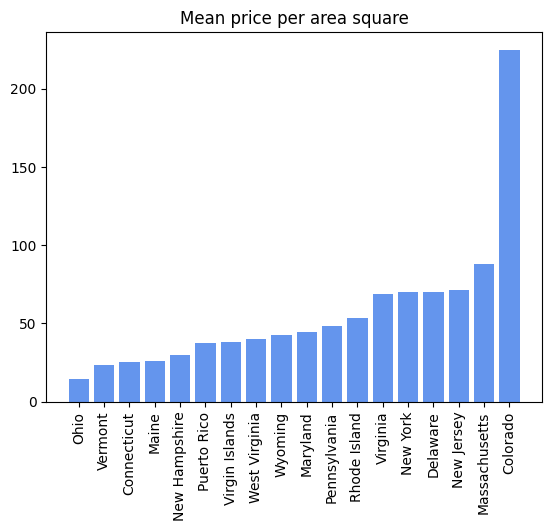

In [186]:
plt.bar(p_per_area['state']
        , p_per_area['average_price']
        , color='cornflowerblue')

ax = plt.gca()
ax.set_xticklabels(labels=p_per_area['state'], rotation=90, ha='center')
plt.title('Mean price per area square')

plt.show()

C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\2002448426.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels=p_per_area['state'], rotation=45, ha='center')


C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\2002448426.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels=price_by_state['state'], rotation=45, ha='center')


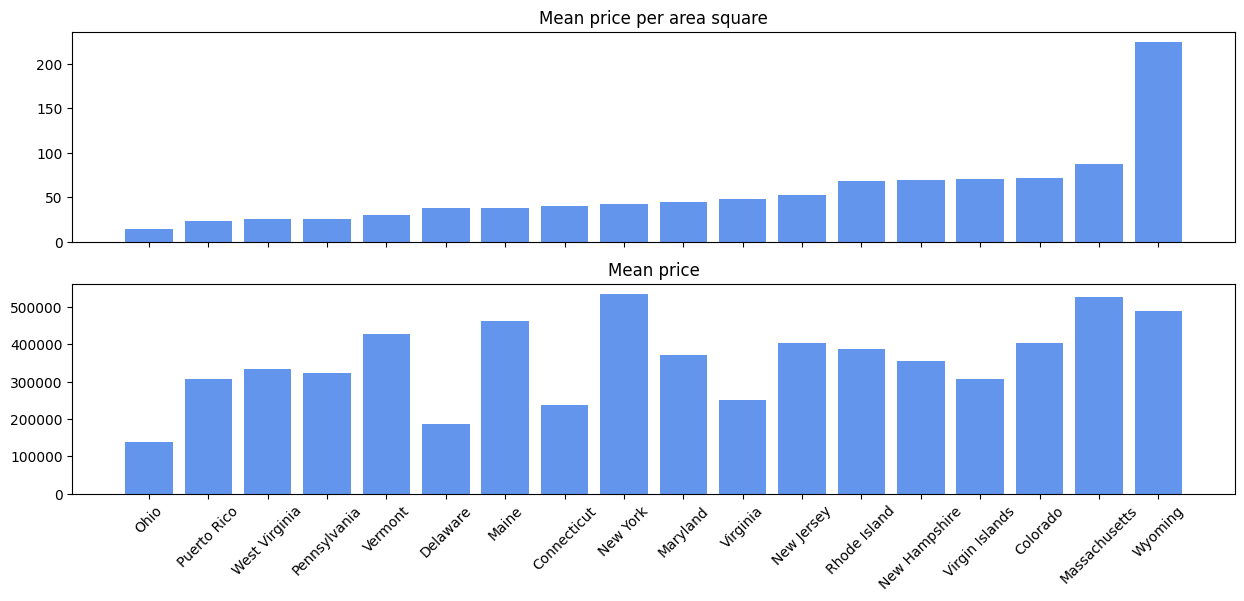

In [187]:
fig, axes = plt.subplots(2,1, sharex=True)
fig.set_size_inches(15,6)

axes[0].bar(p_per_area['state']
        , p_per_area['average_price']
        , color='cornflowerblue')
axes[0].set_xticklabels(labels=p_per_area['state'], rotation=45, ha='center')
axes[0].set_title('Mean price per area square')

axes[1].bar(price_by_state['state']
        , price_by_state['average_price']
        , color='cornflowerblue')
axes[1].set_xticklabels(labels=price_by_state['state'], rotation=45, ha='center')
axes[1].set_title('Mean price')

plt.show()

## Finding 7
* Ohio is the state whose the least valuable houses (both in absolute and per_area)
* Wyominng, Massachusetts, Colorado houses have the highest value per area, and also high mean price

**Q8: What factors affecting price?**

<Axes: >

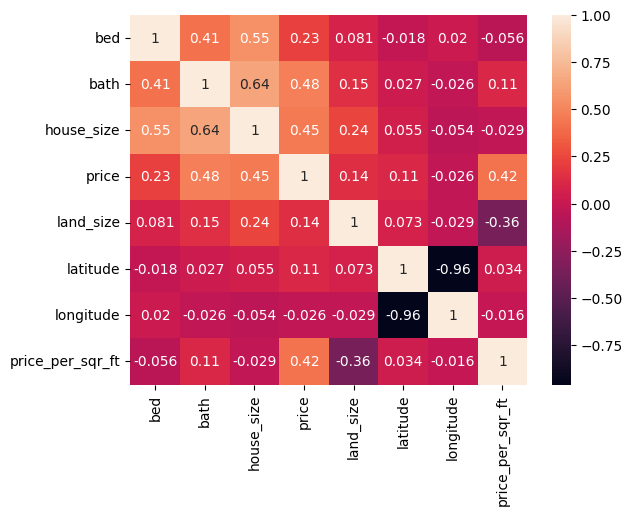

In [188]:
correlation = df.loc[:,df.dtypes == 'float64'].corr()

sns.heatmap(correlation, annot=True)

In [189]:
from scipy.stats.stats import pearsonr

x=df[df['land_size'].isna() == False]['land_size']
y=df[df['land_size'].isna() == False]['price']

pearsonr(x,y)

C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\4167685891.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


PearsonRResult(statistic=0.1372000110700276, pvalue=0.0)

In [190]:
from scipy.stats.stats import pearsonr

x=df[df['bed'].isna() == False]['bed']
y=df[df['bed'].isna() == False]['price']

pearsonr(x,y)

C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\2877474195.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


PearsonRResult(statistic=0.2251132585540302, pvalue=0.0)

In [191]:
from scipy.stats.stats import pearsonr

x=df[df['bath'].isna() == False]['bath']
y=df[df['bath'].isna() == False]['price']

pearsonr(x,y)

C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\2930605042.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


PearsonRResult(statistic=0.4774890176641987, pvalue=0.0)

In [192]:
from scipy.stats.stats import pearsonr

x=df[df['house_size'].isna() == False]['house_size']
y=df[df['house_size'].isna() == False]['price']

pearsonr(x,y)

C:\Users\ASUS FLIP 14\AppData\Local\Temp\ipykernel_13028\1729955808.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


PearsonRResult(statistic=0.45080671361419045, pvalue=0.0)

# Geomap preparation

In [193]:
df.to_csv('for_geo.csv')